In [ ]:
(1) II. 데이터 셋에서 주어진 특징들을 선택하여 CPU 성능 즉, “PRP” 변수를 예측하는 Pipeline 기반 다중 회귀 모델링을 프로그래밍 하시오.

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import missingno as msn
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV,train_test_split,cross_val_score
from sklearn.linear_model import SGDRegressor, LinearRegression, Ridge
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import VotingRegressor, GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 209 entries, 0 to 208
Data columns (total 10 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   VendorName  209 non-null    object
 1   ModelName   209 non-null    object
 2   MYCT        209 non-null    int64 
 3   MMIN        209 non-null    int64 
 4   MMAX        209 non-null    int64 
 5   CACH        209 non-null    int64 
 6   CHMIN       209 non-null    int64 
 7   CHMAX       209 non-null    int64 
 8   PRP         209 non-null    int64 
 9   ERP         209 non-null    int64 
dtypes: int64(8), object(2)
memory usage: 16.5+ KB
None
              MYCT          MMIN          MMAX        CACH       CHMIN  \
count   209.000000    209.000000    209.000000  209.000000  209.000000   
mean    203.822967   2867.980861  11796.153110   25.205742    4.698565   
std     260.262926   3878.742758  11726.564377   40.628722    6.816274   
min      17.000000     64.000000     64.000000    0.000000    0

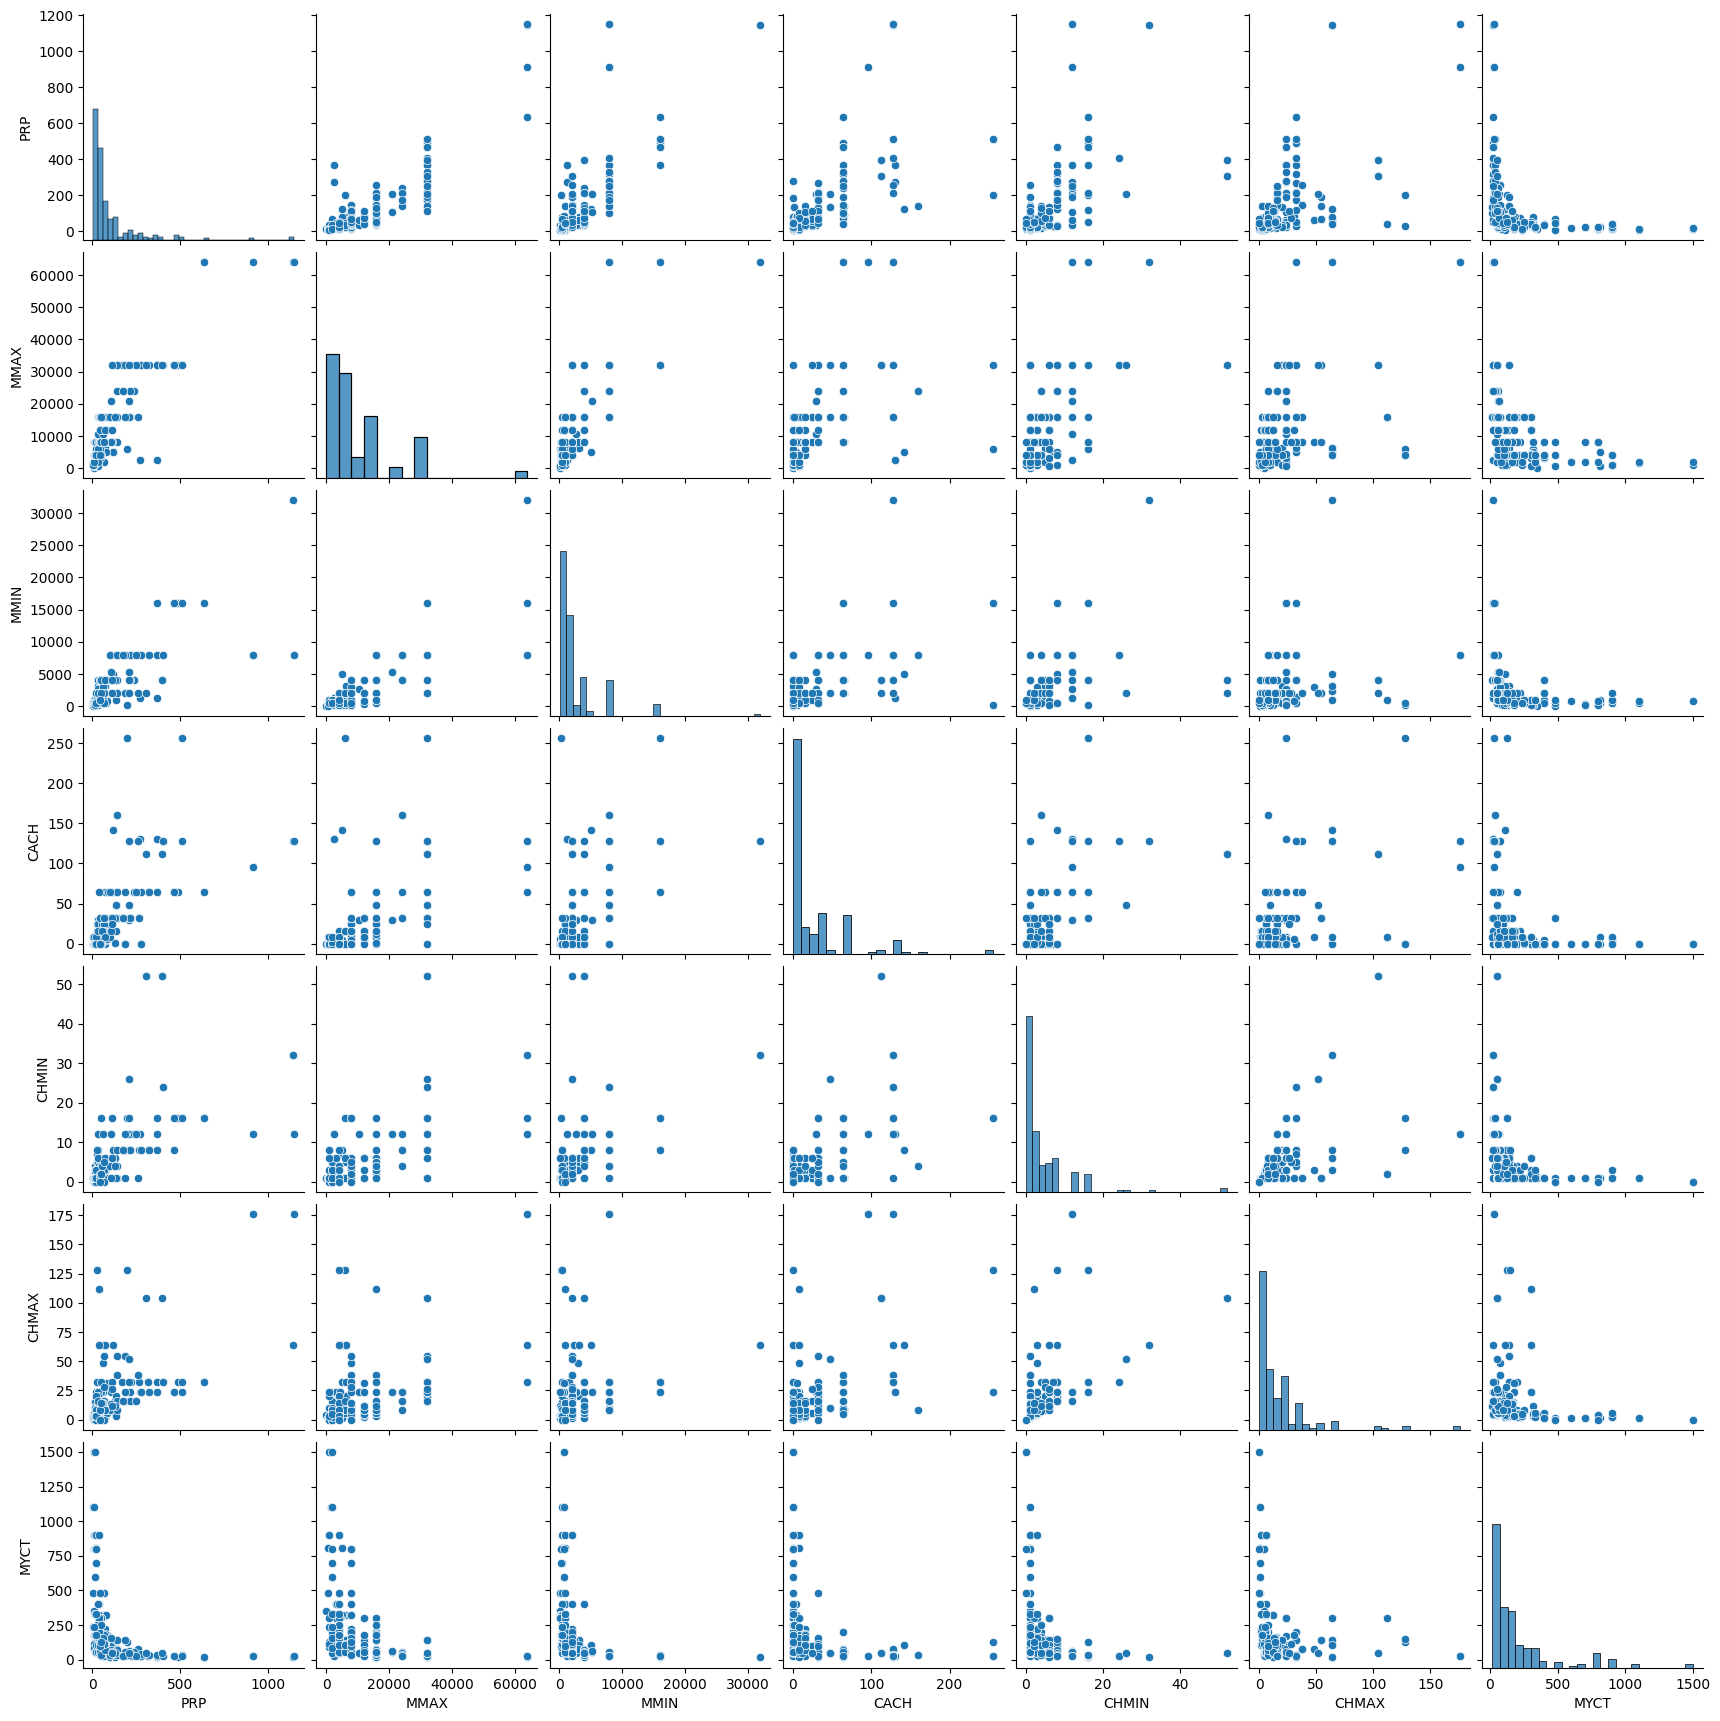

In [18]:
# csv 파일 불러오기
mdu = pd.read_csv('machine.data_update.csv')

# 데이터셋 기본 정보
print(mdu.info())
# 데이터셋 요약 통계
print(mdu.describe())
# 데이터셋 5개행 출력
print(mdu.head())
# 데이터셋의 형태 출력
print(mdu.shape)

# 변수 형 변환
mdu = pd.get_dummies(mdu, columns=['VendorName', 'ModelName'], drop_first=True)

# 데이터분포 시각화
correlation = mdu.corr()['PRP'].abs().sort_values(ascending=False)
print(correlation)

#피처선택
feat = ['PRP', 'MMAX', 'MMIN', 'CACH', 'CHMIN', 'CHMAX', 'MYCT']
X = mdu[feat]
y = mdu['PRP']
sns.pairplot(mdu[feat])
plt.show()

In [16]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#랜덤 포레스트
r_model = RandomForestRegressor(random_state=42)
r_model.fit(X_train, y_train)

# 예측
r_pred = r_model.predict(X_test)

# 성능 평가
r_mse = mean_squared_error(y_test, r_pred)

# GBM
g_model = GradientBoostingRegressor(random_state=42)
g_model.fit(X_train, y_train)

# 예측
g_pred = g_model.predict(X_test)

G_MSE = mean_squared_error(y_test, g_pred)

print(f"Random Forest MSE: {r_mse}")
print(f"Gradient Boosting Machine MSE: {G_MSE}")

Random Forest MSE: 3750.2420023809523
Gradient Boosting Machine MSE: 1608.2353644229065


In [ ]:
# 데이터를 훈련 세트와 테스트 세트로 나누기
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 탐색할 매개변수 그리드 정의
pa_grid = {
    'regressor__fit_intercept': [True, False]  # LinearRegression의 fit_intercept 매개변수
}

# 파이프라인 정의
pipeline = Pipeline([
    ('scaler', StandardScaler()),  # 데이터 스케일링 스텝
    ('regressor', LinearRegression())  # 선형 회귀 모델 스텝
])

# GridSearchCV 객체 생성
g_search = GridSearchCV(pipeline, pa_grid, cv=5)

# 최적 매개변수 탐색
g_search.fit(X_train, y_train)

# 최적 모델 탐색
b_model = g_search.best_estimator_

# 테스트 데이터 예측
y_pred = b_model.predict(X_test)

# 평가 메트릭 계산
MSE = mean_squared_error(y_test, y_pred)
print("MSE:", MSE)
MAE = mean_absolute_error(y_test, y_pred)
print("MAE:", MAE)
R2 = r2_score(y_test, y_pred)
print("결정 계수:", R2)

In [ ]:
# 시각화
plt.figure(figsize=(12, 6))
plt.scatter(y_test, y_pred)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], '--')
plt.xlabel('X')
plt.ylabel('Y')
plt.title('PRP')
plt.show()

In [ ]:
# 결과를 데이터프레임으로 저장
performance_data = {
    'Model': ['Best_estimator', 'Best_estimator', 'Best_estimator'],
    'Data': ['Train', 'Test', 'Cross Validation'],
    'MSE': [mean_squared_error(y_train, grid_search.best_estimator_.predict(X_train)), MSE, cv_mse],
    'MAE': [mean_absolute_error(y_train, grid_search.best_estimator_.predict(X_train)), MAE, cv_mae],
    'R^2': [r2_score(y_train, grid_search.best_estimator_.predict(X_train)), R2, cv_r2]
}

results_df = pd.DataFrame(performance_data)

# CSV 파일로 저장
results_df.to_csv('pipeline_cpu_data.csv', index=False)

               Model              Data          MSE        MAE       R^2
0  Linear Regression             Train  1427.002006  22.321107  0.921823
1  Linear Regression              Test  4379.231957  36.319128  0.916364
2  Linear Regression  Cross Validation  2833.300020  26.864245  0.818086
3     Best_estimator             Train  2050.100722  28.014585  0.893360
4     Best_estimator              Test  5633.068156  48.068801  0.889346
5     Best_estimator  Cross Validation  5197.286706  35.656985  0.736726


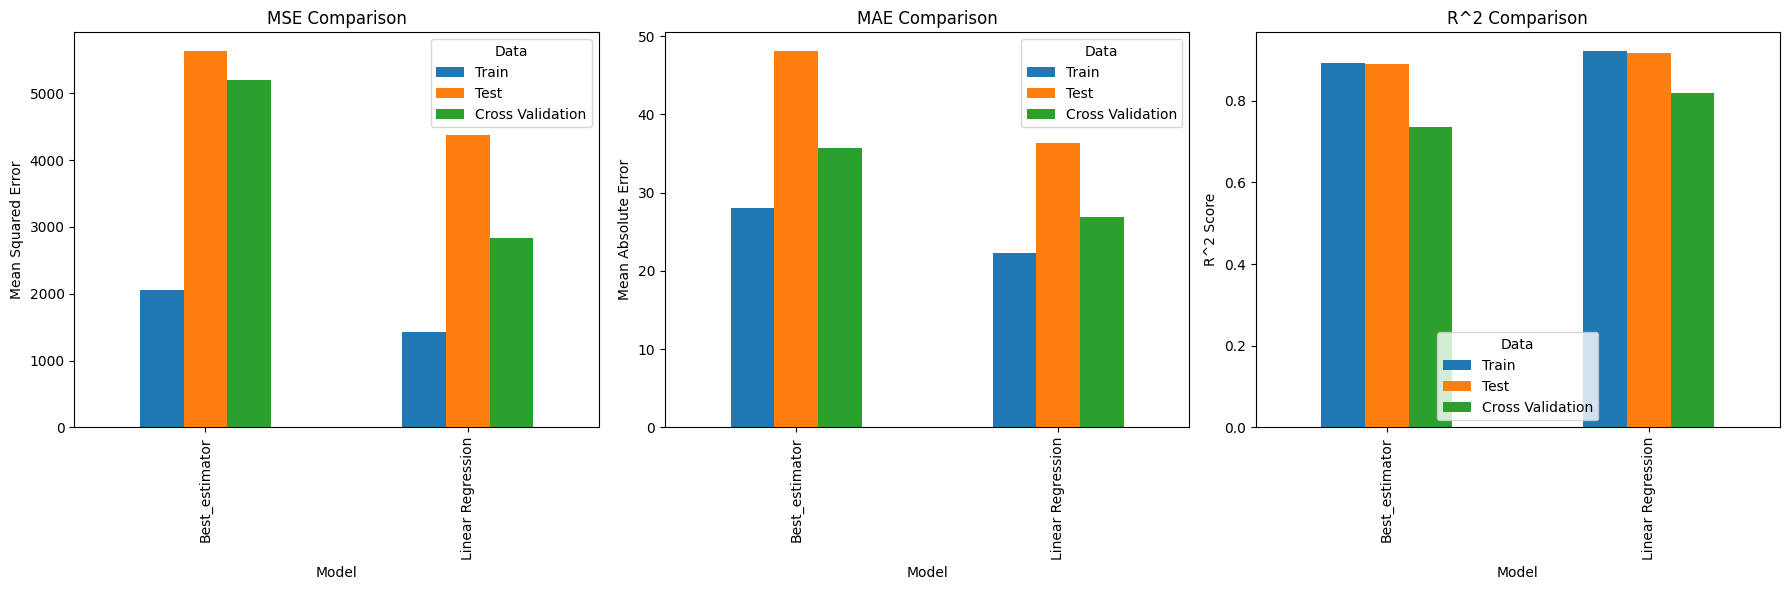

In [8]:
linear_results = pd.read_csv('linear_cpu_data.csv')
pipeline_results = pd.read_csv('pipeline_cpu_data.csv')

combined_results = pd.concat([linear_results, pipeline_results], ignore_index=True)

combined_results['Data'] = pd.Categorical(combined_results['Data'], categories=['Train', 'Test', 'Cross Validation'], ordered=True)

print(combined_results)

mse_data = combined_results.pivot(index='Model', columns='Data', values='MSE')
mae_data = combined_results.pivot(index='Model', columns='Data', values='MAE')
r2_data = combined_results.pivot(index='Model', columns='Data', values='R^2')

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(18, 6))

mse_data.plot(kind='bar', ax=axes[0])
axes[0].set_title('MSE Comparison')
axes[0].set_ylabel('Mean Squared Error')

mae_data.plot(kind='bar', ax=axes[1])
axes[1].set_title('MAE Comparison')
axes[1].set_ylabel('Mean Absolute Error')

r2_data.plot(kind='bar', ax=axes[2])
axes[2].set_title('R^2 Comparison')
axes[2].set_ylabel('R^2 Score')


plt.tight_layout()
plt.show()